## Example. Comparing Newcomb’s speed of light measurements to the posterior predictive distribution

In [1]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ALPHA = 0.11

Measurements of the passage time of light recorded by Newcomb in 1882. The given values divided by 1000 plus 24.8 give the time in millionths of a second for light to traverse a known distance. The ‘true’ value is now considered to be 33.02. 

In [3]:
Dat = np.array([
    28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25, 30, 23, 29, 31, 19, 24, 20,
    36, 32, 36, 28, 25, 21, 28, 29, 37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27,
    28, 27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25, 29, 27, 28, 29, 16, 23
])

---

We consider the noninformative prior distribution $p(\mu,\sigma^2)\propto (\sigma^2)^{-1}$

In [4]:
with pm.Model() as ModelNewcomb:
    mu       = pm.Flat('mu')
    logsigma = pm.Flat('logsigma')
    sigma    = pm.Deterministic('sigma', np.exp(logsigma))

    y = pm.Normal('y', mu=mu, sigma=sigma, observed=Dat)

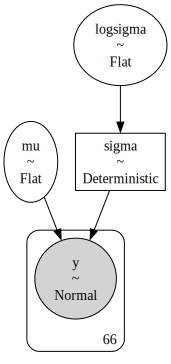

In [5]:
pm.model_to_graphviz(ModelNewcomb)

---

We get a sample from the posterior distribution

In [6]:
with ModelNewcomb:
    TraceNewcomb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, logsigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [7]:
TraceNewcomb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [8]:
pm.summary(TraceNewcomb, hdi_prob=1-ALPHA, stat_focus='median', kind='stats')

,median,mad,eti_5.5%,eti_94.5%
mu,26.230,0.948,24.096,28.409
logsigma,2.380,0.058,2.249,2.530
sigma,10.809,0.628,9.474,12.548


In [9]:
pm.summary(TraceNewcomb, hdi_prob=1-ALPHA, stat_focus='mean', kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
mu,26.222,1.369,24.106,28.411
logsigma,2.384,0.088,2.242,2.521
sigma,10.888,0.965,9.324,12.329


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

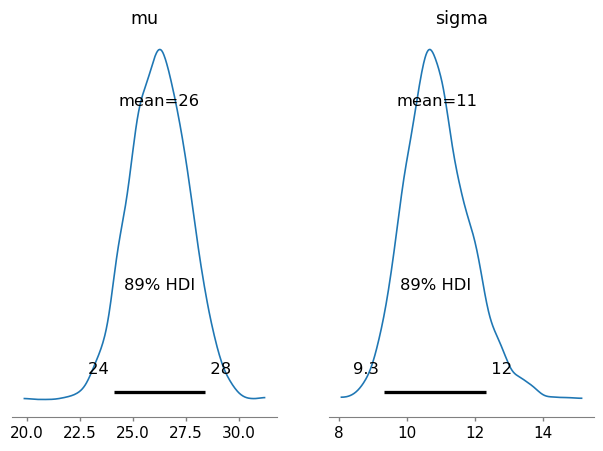

In [18]:
az.plot_posterior(
    TraceNewcomb
    , var_names=['mu', 'sigma']
    #, ref_val=[round(Dat.mean()), round(Dat.std())]
    , hdi_prob=1-ALPHA
    , figsize=(7.5,5)
    , textsize=11
)

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

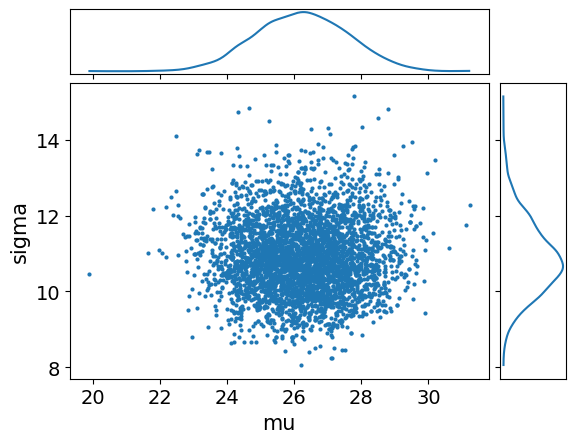

In [19]:
az.plot_pair(TraceNewcomb, var_names=['mu', 'sigma'], marginals=True)

---

We sample from the posterior predictive

In [20]:
with ModelNewcomb:
  TraceNewcomb.extend(pm.sample_posterior_predictive(TraceNewcomb))

Sampling: [y]


In [21]:
TraceNewcomb

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y / y'>

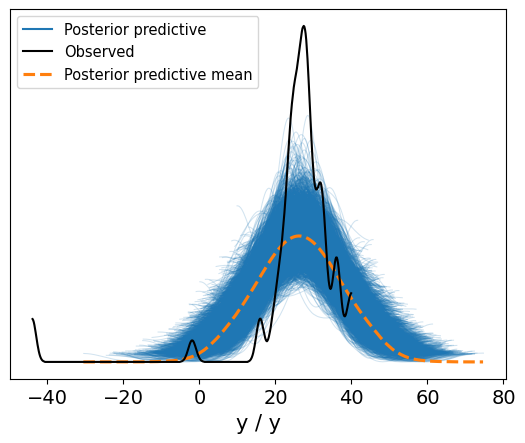

In [22]:
az.plot_ppc(TraceNewcomb)

### We can check if the the posterior predictive samples would look like the original data

In [15]:
if False:
    fig, axs = plt.subplots(ncols=4, nrows=5)

    ind = 0
    for j in range(5):
        for k in range(4):
            axs[j, k].hist(PredictNewcomb.iloc[ind], bins=15, edgecolor='w')
            ind = ind + 1
            
    fig.tight_layout()

All these histograms look different from the histogram of the actual data. Note that there are two inusually low measurements and then a cluster of measurements.

Text(0.5, 1.0, 'Distribution of the measurements')

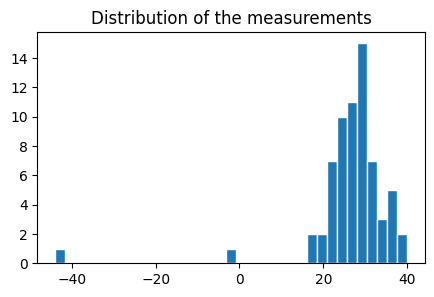

In [23]:
plt.figure(figsize=(5,3))
_, _, _ = plt.hist(Dat, bins=35, edgecolor='w')
plt.title('Distribution of the measurements')

We can also check the predictive sample for each observation

In [26]:
PosteriorPredictiveSummary = az.summary(TraceNewcomb, group='posterior_predictive', hdi_prob=1-ALPHA, kind='stats')
PosteriorPredictiveSummary['Obs'] = Dat

Text(0, 0.5, '89.0% hightest posterior density for each $y$')

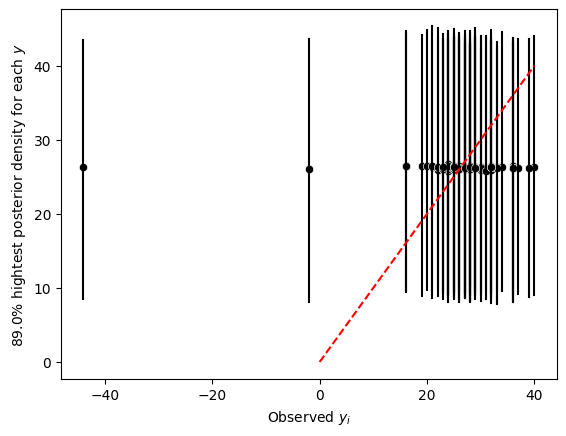

In [27]:
sns.scatterplot(data=PosteriorPredictiveSummary, x='Obs', y='mean', color='k')

for i in range(len(PosteriorPredictiveSummary)):
    plt.plot(
        [PosteriorPredictiveSummary['Obs'][i], PosteriorPredictiveSummary['Obs'][i]],
        [
            PosteriorPredictiveSummary['hdi_' + str(ALPHA/2*100) + '%'][i],
            PosteriorPredictiveSummary['hdi_' + str((1-ALPHA/2)*100) + '%'][i]
        ],
        color='k'
    )
    
plt.plot([0, PosteriorPredictiveSummary['Obs'].max()],
         [0, PosteriorPredictiveSummary['Obs'].max()],
         color='r', linestyle='--')

plt.xlabel(r"Observed $y_i$")
plt.ylabel(str((1-ALPHA)*100) + r"% hightest posterior density for each $y$")

We can check different aspects of the model, like the minimum observation.

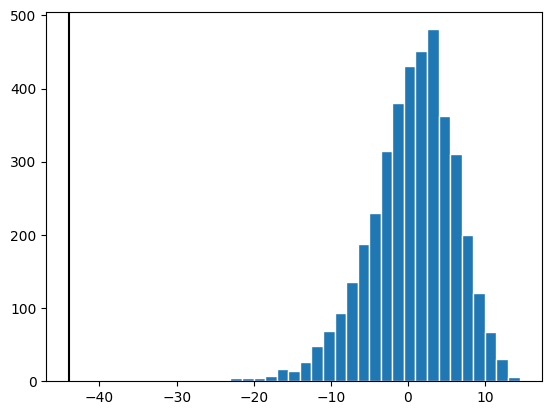

In [28]:
PosteriorPredictiveMinima = TraceNewcomb.posterior_predictive.y.min(axis=2).values.ravel()
_ = plt.hist(PosteriorPredictiveMinima, bins=30, edgecolor='w')
plt.axvline(Dat.min(), color='k')

Or the standard deviation

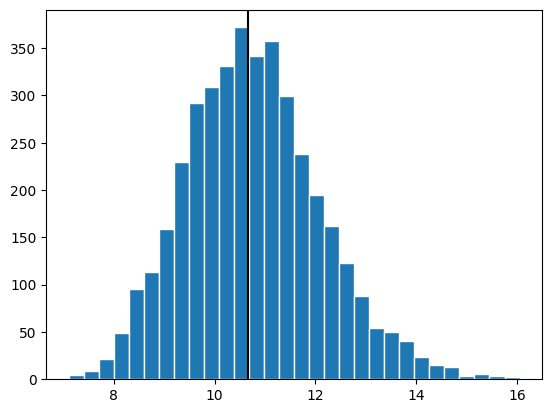

In [29]:
PosteriorPredictiveStd = TraceNewcomb.posterior_predictive.y.std(axis=2).values.ravel()
_ = plt.hist(PosteriorPredictiveStd, bins=30, edgecolor='w')
plt.axvline(Dat.std(), color='k')

In [30]:
#p value
np.mean(PosteriorPredictiveStd >= Dat.std())

0.51025

Or the (a)simmetry of the distribution. We consider a model check based on a test quantity sensitive to assimetry in the center of the distribution, $$T(\mathbf{Y},\mu)=|Y_{(61)}-\mu|-|Y_{(6)}-\mu|.$$ The 61st and 6th order statistics are chosen to represent approx. the 90% and 10% of the points of the distribution. The test quantity should be scattered about zero for a simmetric distribution.

In [32]:
def T_test(y, m):
    y_61, y_6 = np.percentile(y, 90), np.percentile(y, 10)
    return np.abs(y_61 - m) - np.abs(y_6 - m)

Text(0, 0.5, '$T(\\mathbf{Y}^{rep}-\\mu)$')

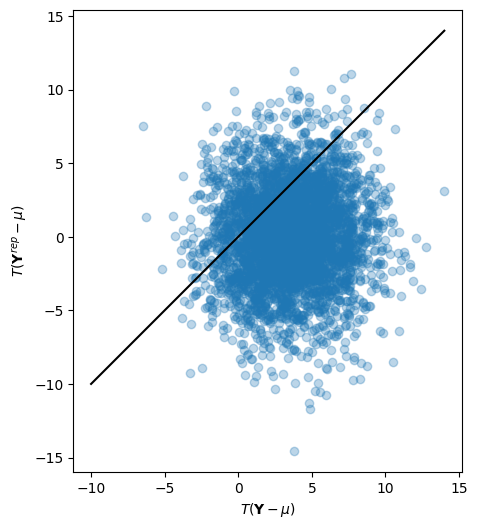

In [33]:
x_li = []
z_li = []

for i in range(TraceNewcomb.posterior_predictive.y.shape[0]):
    for j in range(TraceNewcomb.posterior_predictive.y.shape[1]):
        y_ = TraceNewcomb.posterior_predictive.y[i][j].values
        mu_ = TraceNewcomb.posterior.mu[i][j].values
        
        z_li.append(T_test(y_, mu_))
        x_li.append(T_test(Dat, mu_))

plt.figure(figsize=(7, 6))
plt.scatter(x_li, z_li, alpha=0.3)
plt.plot([-10, 14], [-10, 14], color='k')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.xlabel(r"$T(\mathbf{Y}-\mu)$")
plt.ylabel(r"$T(\mathbf{Y}^{rep}-\mu)$")

In [34]:
pr = [] 
for i, j in zip(x_li, z_li):
    if j >= i:
        pr.append(1)

sum(pr) / len(x_li)

0.197